<!-- dom:TITLE: From Variational Monte Carlo to Boltzmann Machines and Machine Learning -->
# From Variational Monte Carlo to Boltzmann Machines and Machine Learning
<!-- dom:AUTHOR: Morten Hjorth-Jensen  Email hjensen@msu.edu  Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University, East Lansing, 48824 MI, USA -->
<!-- Author: -->  
**Morten Hjorth-Jensen  Email hjensen@msu.edu  Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University, East Lansing, 48824 MI, USA**

Date: **Notebook 1:  Variational Monte Carlo**

## Introduction

### Structure and Aims

These notebooks serve the aim of linking traditional variational Monte
Carlo VMC calculations methods with recent progress on solving
many-particle problems using Machine Learning algorithms.

Furthermore, when linking with Machine Learning algorithms, in particular
so-called Boltzmann Machines, there are interesting connections between
these algorithms and so-called [Shadow Wave functions (SWFs)](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.90.053304) (and references therein). The implications of the latter have been explored in various Monte Carlo calculations. 

In total there are three notebooks:
1. the one you are reading now on Variational Monte Carlo methods, 

2. notebook 2 on Machine Learning and quantum mechanical problems and in particular on Boltzmann Machines, 

3. and finally notebook 3 on the link between Boltzmann machines and SWFs. 

### This notebook

In this notebook the aim is to give you an introduction as well as an
understanding of the basic elements that are needed in order to
develop a professional variational Monte Carlo code. We will focus on
a simple system of two particles in an oscillator trap (or
alternatively two fermions moving in a Coulombic potential) which can
interact via repulsive or attrative force.

The advantage of these systems is that for two particles (boson or
fermions) we have analytical solutions for the eigenpairs for the
non-interacting case. Furthermore, for a two- or three-dimensional
system of two electrons moving in a harmonic oscillator trap, we have
[analytical solutions for the interacting case as well](https://iopscience.iop.org/article/10.1088/0305-4470/27/3/040/meta).  

Having analytical eigenpairs is an invaluable feature that allow us 
to assess the physical relevance of the trial wave functions, be
these either from a standard VMC procedure, from Boltzmann Machines or
from Shadow Wave functions.

In this notebook we start with the basics of a VMC calculation and
introduce concepts like Markow Chain Monte Carlo methods and the
Metropolis algorithm, importance sampling and Metropolis-Hastings
algorithm, resampling methods to obtain better estimates of the
statistical errors and minimization of the expectation values of the
energy and the variance. The latter is done in order to obtain the
best possible variational parameters. Furthermore it will define the
so-called **cost** function, a commonly encountered quantity in Machine
Learning algorithms. Minimizing the latter is the one which leads to
the determination of the optimal parameters in basically all Machine Learning algorithms.
For our purposes, it will serve as the first link between VMC methods and Machine Learning methods.

Topics like Markov Chain Monte Carlo and various resampling techniques
are also central to Machine Learning methods. Presenting them in the
context of VMC approaches leads hopefully to an easier starting point
for the understanding of these methods.

Finally, the reader may ask what do we actually want to achieve with
complicating life with Machine Learning methods when we can easily
study interacting systems with standard Monte Carlo approaches.  Our
hope is that by adding additional degrees of freedom via Machine
Learning algorithms, we can let the algorithms we employ learn the
parameters of the model via a given optimization algorithm. In
standard Monte Carlo calculations the practitioners end fine tuning
the trial wave function using all possible insights about the system
understudy. This may not always lead to the best possible ansatz and
can in the long run be rather time-consuming. In fields like nuclear
many-body physics with complicated interaction terms, guessing an
analytical form for the trial wave fuction can be difficult. Letting
the machine learn the form of the trial function or find the optimal
parameters may lead to insights about the problem which cannot be
obtained by selecting various trial wave functions.

The emerging and rapidly expanding fields of Machine Learning and Quantum Computing hold also great promise in tackling the 
dimensionality problems (the so-called dimensionality curse in many-body problems) we encounter when studying 
complicated many-body problems. 
The approach to Machine Learning we will focus on 
 is inspired by the idea of representing the wave function with
a restricted Boltzmann machine (RBM), presented recently by [G. Carleo and M. Troyer, Science **355**, Issue 6325, pp. 602-606 (2017)](http://science.sciencemag.org/content/355/6325/602). They
named such a wave function/network a *neural network quantum state* (NQS). In their article they apply it to the quantum mechanical
spin lattice systems of the Ising model and Heisenberg model, with
encouraging results.

Machine learning (ML) is an extremely rich field, in spite of its young age. The
increases we have seen during the last three decades in computational
capabilities have been followed by developments of methods and
techniques for analyzing and handling large date sets, relying heavily
on statistics, computer science and mathematics.  The field is rather
new and developing rapidly. 
Machine learning is the science of giving computers the ability to
learn without being explicitly programmed.  The idea is that there
exist generic algorithms which can be used to find patterns in a broad
class of data sets without having to write code specifically for each
problem. The algorithm will build its own logic based on the data.

Machine learning is a subfield of computer science, and is closely
related to computational statistics.  It evolved from the study of
pattern recognition in artificial intelligence (AI) research, and has
made contributions to AI tasks like computer vision, natural language
processing and speech recognition. It has also, especially in later
years, found applications in a wide variety of other areas, including
bioinformatics, economy, physics, finance and marketing.
An excellent reference we will come to back to is [Mehta *et al.*, arXiv:1803.08823](https://arxiv.org/abs/1803.08823).

Our focus will first be on the basics of VMC calculations. 



## Basic Quantum Monte Carlo

We start with the variational principle.
Given a hamiltonian $H$ and a trial wave function $\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})$, the variational principle states that the expectation value of $\langle H \rangle$, defined through

$$
E[H]= \langle H \rangle =
   \frac{\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R};\boldsymbol{\alpha})H(\boldsymbol{R})\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})}
        {\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R};\boldsymbol{\alpha})\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})},
$$

is an upper bound to the ground state energy $E_0$ of the hamiltonian $H$, that is

$$
E_0 \le \langle H \rangle .
$$

In general, the integrals involved in the calculation of various  expectation values  are multi-dimensional ones. Traditional integration methods such as the Gauss-Legendre will not be adequate for say the  computation of the energy of a many-body system.

Here we have defined the vector $\boldsymbol{R} =[\boldsymbol{r}_1,\boldsymbol{r}_2,\dots,\boldsymbol{r}_n}]$  as an array that contains the positions of all particles $n$ while the vector $\boldsymbol{\alpha} = [\alpha_1,\alpha_2,\dots,\alpha_m]$ contains the variational parameters of the model, $m$ in total. 

The trial wave function can be expanded in the eigenstates of the hamiltonian since they form a complete set, viz.,

$$
\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})=\sum_i a_i\Psi_i(\boldsymbol{R}),
$$

and assuming the set of eigenfunctions to be normalized one obtains

$$
\frac{\sum_{nm}a^*_ma_n \int d\boldsymbol{R}\Psi^{\ast}_m(\boldsymbol{R})H(\boldsymbol{R})\Psi_n(\boldsymbol{R})}
        {\sum_{nm}a^*_ma_n \int d\boldsymbol{R}\Psi^{\ast}_m(\boldsymbol{R})\Psi_n(\boldsymbol{R})} =\frac{\sum_{n}a^2_n E_n}
        {\sum_{n}a^2_n} \ge E_0,
$$

where we used that $H(\boldsymbol{R})\Psi_n(\boldsymbol{R})=E_n\Psi_n(\boldsymbol{R})$.
In general, the integrals involved in the calculation of various  expectation
values  are multi-dimensional ones. 
The variational principle yields the lowest state of a given symmetry.

In most cases, a wave function has only small values in large parts of 
configuration space, and a straightforward procedure which uses
homogenously distributed random points in configuration space 
will most likely lead to poor results. This may suggest that some kind
of importance sampling combined with e.g., the Metropolis algorithm 
may be  a more efficient way of obtaining the ground state energy.
The hope is then that those regions of configurations space where
the wave function assumes appreciable values are sampled more 
efficiently. 

The tedious part in a VMC calculation is the search for the variational
minimum. A good knowledge of the system is required in order to carry out
reasonable VMC calculations. This is not always the case, 
and often VMC calculations 
serve rather as the starting
point for so-called diffusion Monte Carlo calculations (DMC). DMC is a way of
solving exactly the many-body Schroedinger equation by means of 
a stochastic procedure. A good guess on the binding energy
and its wave function is however necessary. 
A carefully performed VMC calculation can aid in this context. 


The basic procedure of a Variational Monte Carlo calculations consists thus of 

1. Construct first a trial wave function $\psi_T(\boldsymbol{R};\boldsymbol{\alpha})$,  for a many-body system consisting of $n$ particles located at positions  $\boldsymbol{R}=(\boldsymbol{R}_1,\dots ,\boldsymbol{R}_n)$. The trial wave function depends on $\alpha$ variational parameters $\boldsymbol{\alpha}=(\alpha_1,\dots ,\alpha_M)$.

2. Then we evaluate the expectation value of the hamiltonian $H$

$$
\overline{E}[\boldsymbol{alpha}]=\frac{\int d\boldsymbol{R}\Psi^{\ast}_{T}(\boldsymbol{R},\boldsymbol{\alpha})H(\boldsymbol{R})\Psi_{T}(\boldsymbol{R},\boldsymbol{\alpha})}
        {\int d\boldsymbol{R}\Psi^{\ast}_{T}(\boldsymbol{R},\boldsymbol{\alpha})\Psi_{T}(\boldsymbol{R},\boldsymbol{\alpha})}.
$$

1. Thereafter we vary $\boldsymbol{\alpha}$ according to some minimization algorithm and return eventually to the first step if we are not satisfied with the results.

Here we have used the notation $\overline{E}$ to label the expectation value of the energy. 

### Linking with standard statistical expressions for expectation values

In order to bring in the Monte Carlo machinery, we define first a likelihood distribution, or probability density distribution (PDF). Using our ansatz for the trial wave function $\psi_T(\boldsymbol{R};\boldsymbol{\alpha})$.

$$
P(\boldsymbol{R})= \frac{\left|\psi_T(\boldsymbol{R};\boldsymbol{\alpha})\right|^2}{\int \left|\psi_T(\boldsymbol{R};\boldsymbol{\alpha})\right|^2d\boldsymbol{R}}.
$$

This is our new probability distribution function  (PDF).
The approximation to the expectation value of the Hamiltonian is now

$$
\overline{E}[\boldsymbol{\alpha}] = 
   \frac{\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R};\boldsymbol{\alpha})H(\boldsymbol{R})\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})}
        {\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R};\boldsymbol{\alpha})\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})}.
$$

Define a new quantity

<!-- Equation labels as ordinary links -->
<div id="eq:locale1"></div>

$$
E_L(\boldsymbol{R};\boldsymbol{\alpha})=\frac{1}{\psi_T(\boldsymbol{R};\boldsymbol{\alpha})}H\psi_T(\boldsymbol{R};\boldsymbol{\alpha}),
\label{eq:locale1} \tag{1}
$$

called the local energy, which, together with our trial PDF yields

<!-- Equation labels as ordinary links -->
<div id="eq:vmc1"></div>

$$
\overline{E}[\boldsymbol{\alpha}]=\int P(\boldsymbol{R})E_L(\boldsymbol{R};\boldsymbol{\alpha}) d\boldsymbol{R}\approx \frac{1}{N}\sum_{i=1}^NE_L(\boldsymbol{R_i};\boldsymbol{\alpha})
\label{eq:vmc1} \tag{2}
$$

with $N$ being the number of Monte Carlo samples.

The Algorithm for performing a variational Monte Carlo calculations runs thus as this

   * Initialisation: Fix the number of Monte Carlo steps. Choose an initial $\boldsymbol{R}$ and variational parameters $\alpha$ and calculate $\left|\psi_T^{\alpha}(\boldsymbol{R})\right|^2$. 

   * Initialise the energy and the variance and start the Monte Carlo calculation.

      * Calculate  a trial position  $\boldsymbol{R}_p=\boldsymbol{R}+r*step$ where $r$ is a random variable $r \in [0,1]$.

      * Metropolis algorithm to accept or reject this move  $w = P(\boldsymbol{R}_p)/P(\boldsymbol{R})$.

      * If the step is accepted, then we set $\boldsymbol{R}=\boldsymbol{R}_p$. 

      * Update averages


   * Finish and compute final averages.

Observe that the jumping in space is governed by the variable *step*. This is called brute-force sampling.
Need importance sampling to get more relevant sampling, see lectures below.


### Simple example, the hydrogen atom

The radial Schroedinger equation for the hydrogen atom can be
written as (when we have gotten rid of the first derivative term in the kinetic energy and used $rR(r)=u(r)$)

$$
-\frac{\hbar^2}{2m}\frac{\partial^2 u(r)}{\partial r^2}-
\left(\frac{ke^2}{r}-\frac{\hbar^2l(l+1)}{2mr^2}\right)u(r)=Eu(r).
$$

or with dimensionless variables

<!-- Equation labels as ordinary links -->
<div id="eq:hydrodimless1"></div>

$$
-\frac{1}{2}\frac{\partial^2 u(\rho)}{\partial \rho^2}-
\frac{u(\rho)}{\rho}+\frac{l(l+1)}{2\rho^2}u(\rho)-\lambda u(\rho)=0,
\label{eq:hydrodimless1} \tag{3}
$$

with the hamiltonian

$$
H=-\frac{1}{2}\frac{\partial^2 }{\partial \rho^2}-
\frac{1}{\rho}+\frac{l(l+1)}{2\rho^2}.
$$

Use variational parameter $\alpha$ in the trial
wave function

<!-- Equation labels as ordinary links -->
<div id="eq:trialhydrogen"></div>

$$
u_T^{\alpha}(\rho)=\alpha\rho e^{-\alpha\rho}. 
\label{eq:trialhydrogen} \tag{4}
$$

Inserting this wave function into the expression for the
local energy $E_L$ gives

$$
E_L(\rho)=-\frac{1}{\rho}-
              \frac{\alpha}{2}\left(\alpha-\frac{2}{\rho}\right).
$$

We note that at $\alpha=1$ we obtain the exact
result, and the variance is zero, as it should. The reason is that 
we then have the exact wave function, and the action of the hamiltionan
on the wave function

$$
H\psi = \mathrm{constant}\times \psi,
$$

yields just a constant. The integral which defines various 
expectation values involving moments of the hamiltonian becomes then

$$
\langle H^n \rangle =
   \frac{\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R})H^n(\boldsymbol{R})\Psi_T(\boldsymbol{R})}
        {\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R})\Psi_T(\boldsymbol{R})}=
\mathrm{constant}\times\frac{\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R})\Psi_T(\boldsymbol{R})}
        {\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R})\Psi_T(\boldsymbol{R})}=\mathrm{constant}.
$$

**This gives an important information: the exact wave function leads to zero variance!**
Variation is then performed by minimizing both the energy and the variance.


## The Metropolis algorithm

The Metropolis algorithm , see [the original article](http://scitation.aip.org/content/aip/journal/jcp/21/6/10.1063/1.1699114) was invented by Metropolis et. al
and is often simply called the Metropolis algorithm.
It is a method to sample a normalized probability
distribution by a stochastic process. We define $\mathbf{P}_i^{(n)}$ to
be the probability for finding the system in the state $i$ at step $n$.
The algorithm is then

* Sample a possible new state $j$ with some probability $T_{i\rightarrow j}$.

* Accept the new state $j$ with probability $A_{i \rightarrow j}$ and use it as the next sample. With probability $1-A_{i\rightarrow j}$ the move is rejected and the original state $i$ is used again as a sample.

We wish to derive the required properties of $T$ and $A$ such that
$\mathbf{P}_i^{(n\rightarrow \infty)} \rightarrow p_i$ so that starting
from any distribution, the method converges to the correct distribution.
Note that the description here is for a discrete probability distribution.
Replacing probabilities $p_i$ with expressions like $p(x_i)dx_i$ will
take all of these over to the corresponding continuum expressions.

The dynamical equation for $\mathbf{P}_i^{(n)}$ can be written directly from
the description above. The probability of being in the state $i$ at step $n$
is given by the probability of being in any state $j$ at the previous step,
and making an accepted transition to $i$ added to the probability of
being in the state $i$, making a transition to any state $j$ and
rejecting the move:

$$
\mathbf{P}^{(n)}_i = \sum_j \left [
\mathbf{P}^{(n-1)}_jT_{j\rightarrow i} A_{j\rightarrow i} 
+\mathbf{P}^{(n-1)}_iT_{i\rightarrow j}\left ( 1- A_{i\rightarrow j} \right)
\right ] \,.
$$

Since the probability of making some transition must be 1,
$\sum_j T_{i\rightarrow j} = 1$, and the above equation becomes

$$
\mathbf{P}^{(n)}_i = \mathbf{P}^{(n-1)}_i +
 \sum_j \left [
\mathbf{P}^{(n-1)}_jT_{j\rightarrow i} A_{j\rightarrow i} 
-\mathbf{P}^{(n-1)}_iT_{i\rightarrow j}A_{i\rightarrow j}
\right ] \,.
$$

For large $n$ we require that $\mathbf{P}^{(n\rightarrow \infty)}_i = p_i$,
the desired probability distribution. Taking this limit, gives the
balance requirement

$$
\sum_j \left [
p_jT_{j\rightarrow i} A_{j\rightarrow i}
-p_iT_{i\rightarrow j}A_{i\rightarrow j}
\right ] = 0 \,.
$$

The balance requirement is very weak. Typically the much stronger detailed
balance requirement is enforced, that is rather than the sum being
set to zero, we set each term separately to zero and use this
to determine the acceptance probabilities. Rearranging, the result is

$$
\frac{ A_{j\rightarrow i}}{A_{i\rightarrow j}}
= \frac{p_iT_{i\rightarrow j}}{ p_jT_{j\rightarrow i}} \,.
$$

The Metropolis choice is to maximize the $A$ values, that is

$$
A_{j \rightarrow i} = \min \left ( 1,
\frac{p_iT_{i\rightarrow j}}{ p_jT_{j\rightarrow i}}\right ).
$$

Other choices are possible, but they all correspond to multilplying
$A_{i\rightarrow j}$ and $A_{j\rightarrow i}$ by the same constant
smaller than unity.\footnote{The penalty function method uses just such
a factor to compensate for $p_i$ that are evaluated stochastically
and are therefore noisy.}

Having chosen the acceptance probabilities, we have guaranteed that
if the  $\mathbf{P}_i^{(n)}$ has equilibrated, that is if it is equal to $p_i$,
it will remain equilibrated. Next we need to find the circumstances for
convergence to equilibrium.

The dynamical equation can be written as

$$
\mathbf{P}^{(n)}_i = \sum_j M_{ij}\mathbf{P}^{(n-1)}_j
$$

with the matrix $M$ given by

$$
M_{ij} = \delta_{ij}\left [ 1 -\sum_k T_{i\rightarrow k} A_{i \rightarrow k}
\right ] + T_{j\rightarrow i} A_{j\rightarrow i} \,.
$$

Summing over $i$ shows that $\sum_i M_{ij} = 1$, and since
$\sum_k T_{i\rightarrow k} = 1$, and $A_{i \rightarrow k} \leq 1$, the
elements of the matrix satisfy $M_{ij} \geq 0$. The matrix $M$ is therefore
a stochastic matrix.


The Metropolis method is simply the power method for computing the
right eigenvector of $M$ with the largest magnitude eigenvalue.
By construction, the correct probability distribution is a right eigenvector
with eigenvalue 1. Therefore, for the Metropolis method to converge
to this result, we must show that $M$ has only one eigenvalue with this
magnitude, and all other eigenvalues are smaller.


### The system: two electrons in a harmonic oscillator trap in two dimensions

The Hamiltonian of the quantum dot is given by

$$
\hat{H} = \hat{H}_0 + \hat{V},
$$

where $\hat{H}_0$ is the many-body HO Hamiltonian, and $\hat{V}$ is the
inter-electron Coulomb interactions. In dimensionless units,

$$
\hat{V}= \sum_{i < j}^N \frac{1}{r_{ij}},
$$

with $r_{ij}=\sqrt{\mathbf{r}_i^2 - \mathbf{r}_j^2}$.

This leads to the  separable Hamiltonian, with the relative motion part given by ($r_{ij}=r$)

$$
\hat{H}_r=-\nabla^2_r + \frac{1}{4}\omega^2r^2+ \frac{1}{r},
$$

plus a standard Harmonic Oscillator problem  for the center-of-mass motion.
This system has analytical solutions in two and three dimensions ([M. Taut 1993 and 1994](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.48.3561)). 

We want to perform  a Variational Monte Carlo calculation of the ground state of two electrons in a quantum dot well with different oscillator energies, assuming total spin $S=0$.
Our trial wave function has the following form

<!-- Equation labels as ordinary links -->
<div id="eq:trial"></div>

$$
\begin{equation}
   \psi_{T}(\boldsymbol{r}_1,\boldsymbol{r}_2) = 
   C\exp{\left(-\alpha_1\omega(r_1^2+r_2^2)/2\right)}
   \exp{\left(\frac{r_{12}}{(1+\alpha_2 r_{12})}\right)}, 
\label{eq:trial} \tag{5}
\end{equation}
$$

where the $\alpha$s represent our variational parameters, two in this case.

Why does the trial function look like this? How did we get there? **This will be our main motivation** for switching to
Machine Learning.


To find an ansatz for the correlated part of the wave function, it is useful to rewrite the two-particle
local energy in terms of the relative and center-of-mass motion.
Let us denote the distance between the two electrons as
$r_{12}$. We omit the center-of-mass motion since we are only interested in the case when
$r_{12} \rightarrow 0$. The contribution from the center-of-mass (CoM) variable $\boldsymbol{R}_{\mathrm{CoM}}$
gives only a finite contribution.
We focus only on the terms that are relevant for $r_{12}$ and for three dimensions. The relevant local energy becomes then

$$
\lim_{r_{12} \rightarrow 0}E_L(R)=
    \frac{1}{{\cal R}_T(r_{12})}\left(2\frac{d^2}{dr_{ij}^2}+\frac{4}{r_{ij}}\frac{d}{dr_{ij}}+
\frac{2}{r_{ij}}-\frac{l(l+1)}{r_{ij}^2}+2E
\right){\cal R}_T(r_{12}) = 0.
$$

Set $l=0$ and we have the so-called **cusp** condition

$$
\frac{d {\cal R}_T(r_{12})}{dr_{12}} = -\frac{1}{2(l+1)}
{\cal R}_T(r_{12})\qquad r_{12}\to 0
$$

The above  results in

$$
{\cal R}_T  \propto \exp{(r_{ij}/2)},
$$

for anti-parallel spins and

$$
{\cal R}_T  \propto \exp{(r_{ij}/4)},
$$

for anti-parallel spins. 
This is the so-called cusp condition for the relative motion, resulting in a minimal requirement
for the correlation part of the wave fuction.
For general systems containing more than say two electrons, we have this
condition for each electron pair $ij$.

### First code attempt for the two-electron case

We start we a  more general setup which allows to store files and figures in user defined folders.

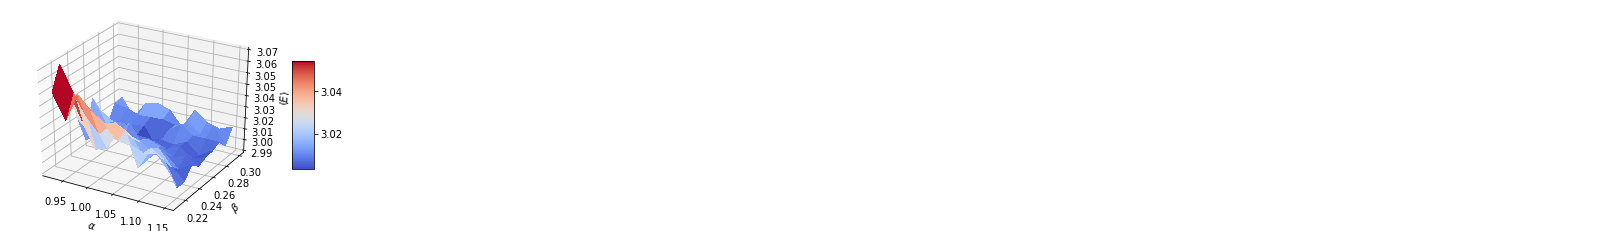

In [1]:
%matplotlib inline

# Common imports
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "FigureFiles"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, FIGURE_ID, fig_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')


# 2-electron VMC for quantum dot system in two dimensions
# Brute force Metropolis, no importance sampling and no energy minimization

outfile = open("Results/DataFiles/qdotmetro.dat",'w')

# 2-electron VMC for quantum dot system in two dimensions
# Brute force Metropolis, no importance sampling and no energy minimization
from math import exp, sqrt
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys
from numba import jit

#outfile = open(outfilename,'w')

# Trial wave function for the 2-electron quantum dot in two dims
def WaveFunction(r,alpha,beta):
    r1 = r[0,0]**2 + r[0,1]**2
    r2 = r[1,0]**2 + r[1,1]**2
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = r12/(1+beta*r12)
    return exp(-0.5*alpha*(r1+r2)+deno)

# Local energy  for the 2-electron quantum dot in two dims, using analytical local energy
def LocalEnergy(r,alpha,beta):
    
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    return 0.5*(1-alpha*alpha)*(r1 + r2) +2.0*alpha + 1.0/r12+deno2*(alpha*r12-deno2+2*beta*deno-1.0/r12)

# The Monte Carlo sampling with the Metropolis algo
# The jit decorator tells Numba to compile this function.
# The argument types will be inferred by Numba when the function is called.
@jit
def MonteCarloSampling():

    NumberMCcycles= 10000
    StepSize = 1.0
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)

    # seed for rng generator
    seed()
    # start variational parameter
    alpha = 0.9
    for ia in range(MaxVariations):
        alpha += .025
        AlphaValues[ia] = alpha
        beta = 0.2 
        for jb in range(MaxVariations):
            beta += .01
            BetaValues[jb] = beta
            energy = energy2 = 0.0
            DeltaE = 0.0
            #Initial position
            for i in range(NumberParticles):
                for j in range(Dimension):
                    PositionOld[i,j] = StepSize * (random() - .5)
            wfold = WaveFunction(PositionOld,alpha,beta)

            #Loop over MC MCcycles
            for MCcycle in range(NumberMCcycles):
                #Trial position moving one particle at the time
                for i in range(NumberParticles):
                    for j in range(Dimension):
                        PositionNew[i,j] = PositionOld[i,j] + StepSize * (random() - .5)
                    wfnew = WaveFunction(PositionNew,alpha,beta)

                    #Metropolis test to see whether we accept the move
                    if random() < wfnew**2 / wfold**2:
                       for j in range(Dimension):
                           PositionOld[i,j] = PositionNew[i,j]
                       wfold = wfnew
                DeltaE = LocalEnergy(PositionOld,alpha,beta)
                energy += DeltaE
                energy2 += DeltaE**2
            #We calculate mean, variance and error ...
            energy /= NumberMCcycles
            energy2 /= NumberMCcycles
            variance = energy2 - energy**2
            error = sqrt(variance/NumberMCcycles)
            Energies[ia,jb] = energy    
            outfile.write('%f %f %f %f %f\n' %(alpha,beta,energy,variance,error))
    return Energies, AlphaValues, BetaValues


#Here starts the main program with variable declarations
NumberParticles = 2
Dimension = 2
MaxVariations = 10
Energies = np.zeros((MaxVariations,MaxVariations))
AlphaValues = np.zeros(MaxVariations)
BetaValues = np.zeros(MaxVariations)
(Energies, AlphaValues, BetaValues) = MonteCarloSampling()
outfile.close()

# Prepare for plots
fig = plt.figure()
ax = fig.gca(projection='3d')
# Plot the surface.
X, Y = np.meshgrid(AlphaValues, BetaValues)
surf = ax.plot_surface(X, Y, Energies,cmap=cm.coolwarm,linewidth=0, antialiased=False)
# Customize the z axis.
zmin = np.matrix(Energies).min()
zmax = np.matrix(Energies).max()
ax.set_zlim(zmin, zmax)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel(r'$\langle E \rangle$')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
save_fig("QdotMetropolis")
plt.show()

## Importance sampling

We need to replace the brute force
Metropolis algorithm with a walk in coordinate space biased by the trial wave function.
This approach is based on the Fokker-Planck equation and the Langevin equation for generating a trajectory in coordinate space.  The link between the Fokker-Planck equation and the Langevin equations are explained, only partly, in the slides below.
An excellent reference on topics like Brownian motion, Markov chains, the Fokker-Planck equation and the Langevin equation is the text by  [Van Kampen](http://www.elsevier.com/books/stochastic-processes-in-physics-and-chemistry/van-kampen/978-0-444-52965-7)
Here we will focus first on the implementation part first.

For a diffusion process characterized by a time-dependent probability density $P(x,t)$ in one dimension the Fokker-Planck
equation reads (for one particle /walker)

$$
\frac{\partial P}{\partial t} = D\frac{\partial }{\partial x}\left(\frac{\partial }{\partial x} -F\right)P(x,t),
$$

where $F$ is a drift term and $D$ is the diffusion coefficient. 


The new positions in coordinate space are given as the solutions of the Langevin equation using Euler's method, namely,
we go from the Langevin equation

$$
\frac{\partial x(t)}{\partial t} = DF(x(t)) +\eta,
$$

with $\eta$ a random variable,
yielding a new position

$$
y = x+DF(x)\Delta t +\xi\sqrt{\Delta t},
$$

where $\xi$ is gaussian random variable and $\Delta t$ is a chosen time step. 
The quantity $D$ is, in atomic units, equal to $1/2$ and comes from the factor $1/2$ in the kinetic energy operator. Note that $\Delta t$ is to be viewed as a parameter. Values of $\Delta t \in [0.001,0.01]$ yield in general rather stable values of the ground state energy.  

The process of isotropic diffusion characterized by a time-dependent probability density $P(\mathbf{x},t)$ obeys (as an approximation) the so-called Fokker-Planck equation

$$
\frac{\partial P}{\partial t} = \sum_i D\frac{\partial }{\partial \mathbf{x_i}}\left(\frac{\partial }{\partial \mathbf{x_i}} -\mathbf{F_i}\right)P(\mathbf{x},t),
$$

where $\mathbf{F_i}$ is the $i^{th}$ component of the drift term (drift velocity) caused by an external potential, and $D$ is the diffusion coefficient. The convergence to a stationary probability density can be obtained by setting the left hand side to zero. The resulting equation will be satisfied if and only if all the terms of the sum are equal zero,

$$
\frac{\partial^2 P}{\partial {\mathbf{x_i}^2}} = P\frac{\partial}{\partial {\mathbf{x_i}}}\mathbf{F_i} + \mathbf{F_i}\frac{\partial}{\partial {\mathbf{x_i}}}P.
$$

The drift vector should be of the form $\mathbf{F} = g(\mathbf{x}) \frac{\partial P}{\partial \mathbf{x}}$. Then,

$$
\frac{\partial^2 P}{\partial {\mathbf{x_i}^2}} = P\frac{\partial g}{\partial P}\left( \frac{\partial P}{\partial {\mathbf{x}_i}}  \right)^2 + P g \frac{\partial ^2 P}{\partial {\mathbf{x}_i^2}}  + g \left( \frac{\partial P}{\partial {\mathbf{x}_i}}  \right)^2.
$$

The condition of stationary density means that the left hand side equals zero. In other words, the terms containing first and second derivatives have to cancel each other. It is possible only if $g = \frac{1}{P}$, which yields

$$
\mathbf{F} = 2\frac{1}{\Psi_T}\nabla\Psi_T,
$$

which is known as the so-called *quantum force*. This term is responsible for pushing the walker towards regions of configuration space where the trial wave function is large, increasing the efficiency of the simulation in contrast to the Metropolis algorithm where the walker has the same probability of moving in every direction.

The Fokker-Planck equation yields a (the solution to the equation) transition probability given by the Green's function

$$
G(y,x,\Delta t) = \frac{1}{(4\pi D\Delta t)^{3N/2}} \exp{\left(-(y-x-D\Delta t F(x))^2/4D\Delta t\right)}
$$

which in turn means that our brute force Metropolis algorithm

$$
A(y,x) = \mathrm{min}(1,q(y,x))),
$$

with $q(y,x) = |\Psi_T(y)|^2/|\Psi_T(x)|^2$ is now replaced by the [Metropolis-Hastings algorithm](http://scitation.aip.org/content/aip/journal/jcp/21/6/10.1063/1.1699114) as well as [Hasting's article](http://biomet.oxfordjournals.org/content/57/1/97.abstract),

$$
q(y,x) = \frac{G(x,y,\Delta t)|\Psi_T(y)|^2}{G(y,x,\Delta t)|\Psi_T(x)|^2}
$$

In [2]:
add python code here

## Technical aspect, improvements and how to define the cost function


**The above procedure is not the smartest one**. Looping over all variational parameters becomes expensive.
Also, we don't use importance sampling and optimizations of the standard deviation (blocking, bootstrap, jackknife). 
Such codes are included in the above Github address.


We can also be smarter and use minimization methods to find the **optimal** variational parameters with fewer Monte Carlo cycles and then 
fire up our heavy artillery. 

One way to achieve this is to minimize the energy as function of the variational parameters.


To find the derivatives of the local energy expectation value as function of the variational parameters, we can use the chain rule and the hermiticity of the Hamiltonian.  

Let us define

$$
\bar{E}_{\alpha_i}=\frac{d\langle  E_L\rangle}{d\alpha_i}.
$$

as the derivative of the energy with respect to the variational parameter $\alpha_i$
We define also the derivative of the trial function (skipping the subindex $T$) as

$$
\bar{\Psi}_{i}=\frac{d\Psi}{d\alpha_i}.
$$

The elements of the gradient of the local energy are then (using the chain rule and the hermiticity of the Hamiltonian)

$$
\bar{E}_{i}= 2\left( \langle \frac{\bar{\Psi}_{i}}{\Psi}E_L\rangle -\langle \frac{\bar{\Psi}_{i}}{\Psi}\rangle\langle E_L \rangle\right).
$$

From a computational point of view it means that you need to compute the expectation values of

$$
\langle \frac{\bar{\Psi}_{i}}{\Psi}E_L\rangle,
$$

and

$$
\langle \frac{\bar{\Psi}_{i}}{\Psi}\rangle\langle E_L\rangle
$$

These integrals are evaluted using MC intergration (with all its possible error sources). 
We can then use methods like stochastic gradient or other minimization methods to find the optimal variational parameters (I don't discuss this topic here, but these methods are very important in ML). 

We have a model, our likelihood function. 

How should we define the cost function?


Suppose the trial function (our model) is the exact wave function. The action of the hamiltionan
on the wave function

$$
H\Psi = \mathrm{constant}\times \Psi,
$$

The integral which defines various 
expectation values involving moments of the hamiltonian becomes then

$$
\langle E^n \rangle =   \langle H^n \rangle =
   \frac{\int d\boldsymbol{R}\Psi^{\ast}(\boldsymbol{R})H^n(\boldsymbol{R})\Psi(\boldsymbol{R})}
        {\int d\boldsymbol{R}\Psi^{\ast}(\boldsymbol{R})\Psi(\boldsymbol{R})}=
\mathrm{constant}\times\frac{\int d\boldsymbol{R}\Psi^{\ast}(\boldsymbol{R})\Psi(\boldsymbol{R})}
        {\int d\boldsymbol{R}\Psi^{\ast}(\boldsymbol{R})\Psi(\boldsymbol{R})}=\mathrm{constant}.
$$

**This gives an important information: If I want the variance, the exact wave function leads to zero variance!**
The variance is defined as

$$
\sigma_E = \langle E^2\rangle - \langle E\rangle^2.
$$

Variation is then performed by minimizing both the energy and the variance.


We can then take the derivatives of

$$
\sigma_E = \langle E^2\rangle - \langle E\rangle^2,
$$

with respect to the variational parameters. The derivatives of the variance can then be used to defined the
so-called Hessian matrix, which in turn allows us to use minimization methods like Newton's method or 
standard gradient methods. 

This leads to however a more complicated expression, with obvious errors when evaluating integrals by Monte Carlo integration. Less used, see however [Filippi and Umrigar](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.94.150201). The expression becomes complicated

$$
\bar{E}_{ij} = 2\left[ \langle (\frac{\bar{\Psi}_{ij}}{\Psi}+\frac{\bar{\Psi}_{j}}{\Psi}\frac{\bar{\Psi}_{i}}{\Psi})(E_L-\langle E\rangle)\rangle -\langle \frac{\bar{\Psi}_{i}}{\Psi}\rangle\bar{E}_j-\langle \frac{\bar{\Psi}_{j}}{\Psi}\rangle\bar{E}_i\right] +\langle \frac{\bar{\Psi}_{i}}{\Psi}E_L{_j}\rangle +\langle \frac{\bar{\Psi}_{j}}{\Psi}E_L{_i}\rangle -\langle \frac{\bar{\Psi}_{i}}{\Psi}\rangle\langle E_L{_j}\rangle \langle \frac{\bar{\Psi}_{j}}{\Psi}\rangle\langle E_L{_i}\rangle.
$$

Evaluating the cost function means having to evaluate the above second derivative of the energy.

In [3]:
# 2-electron VMC code for 2dim quantum dot with importance sampling
# Using gaussian rng for new positions and Metropolis- Hastings 
# No energy minimization
from math import exp, sqrt
from random import random, seed, normalvariate
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys
from numba import jit
from scipy.optimize import minimize


# Trial wave function for the 2-electron quantum dot in two dims
def WaveFunction(r,alpha):
    r1 = r[0,0]**2 + r[0,1]**2
    r2 = r[1,0]**2 + r[1,1]**2
    return exp(-0.5*alpha*(r1+r2))

# Local energy  for the 2-electron quantum dot in two dims, using analytical local energy
def LocalEnergy(r,alpha):
    
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    return 0.5*(1-alpha*alpha)*(r1 + r2) +2.0*alpha

# Derivate of wave function ansatz as function of variational parameters
def DerivativeWFansatz(r,alpha):
    
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    WfDer = -0.5*(r1+r2)
    return  WfDer

# Setting up the quantum force for the two-electron quantum dot, recall that it is a vector
def QuantumForce(r,alpha):

    qforce = np.zeros((NumberParticles,Dimension), np.double)
    qforce[0,:] = -2*r[0,:]*alpha
    qforce[1,:] = -2*r[1,:]*alpha
    return qforce
    
# Computing the derivative of the energy and the energy 
# jit decorator tells Numba to compile this function.
# The argument types will be inferred by Numba when function is called.
@jit
def EnergyMinimization(alpha):

    NumberMCcycles= 1000
    # Parameters in the Fokker-Planck simulation of the quantum force
    D = 0.5
    TimeStep = 0.05
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)
    # Quantum force
    QuantumForceOld = np.zeros((NumberParticles,Dimension), np.double)
    QuantumForceNew = np.zeros((NumberParticles,Dimension), np.double)

    # seed for rng generator 
    seed()
    energy = 0.0
    DeltaE = 0.0
    EnergyDer = 0.0
    DeltaPsi = 0.0
    DerivativePsiE = 0.0
    #Initial position
    for i in range(NumberParticles):
        for j in range(Dimension):
            PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
    wfold = WaveFunction(PositionOld,alpha)
    QuantumForceOld = QuantumForce(PositionOld,alpha)

    #Loop over MC MCcycles
    for MCcycle in range(NumberMCcycles):
        #Trial position moving one particle at the time
        for i in range(NumberParticles):
            for j in range(Dimension):
                PositionNew[i,j] = PositionOld[i,j]+normalvariate(0.0,1.0)*sqrt(TimeStep)+\
                                       QuantumForceOld[i,j]*TimeStep*D
            wfnew = WaveFunction(PositionNew,alpha)
            QuantumForceNew = QuantumForce(PositionNew,alpha)
            GreensFunction = 0.0
            for j in range(Dimension):
                GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*\
	                              (D*TimeStep*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])-\
                                      PositionNew[i,j]+PositionOld[i,j])
      
            GreensFunction = 1.0#exp(GreensFunction)
            ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
            #Metropolis-Hastings test to see whether we accept the move
            if random() <= ProbabilityRatio:
                for j in range(Dimension):
                    PositionOld[i,j] = PositionNew[i,j]
                    QuantumForceOld[i,j] = QuantumForceNew[i,j]
                wfold = wfnew
        DeltaE = LocalEnergy(PositionOld,alpha)
        DerPsi = DerivativeWFansatz(PositionOld,alpha)
        DeltaPsi +=DerPsi
        energy += DeltaE
        DerivativePsiE += DerPsi*DeltaE
            
    # We calculate mean, variance and error (no blocking applied)
    energy /= NumberMCcycles
    DerivativePsiE /= NumberMCcycles
    DeltaPsi /= NumberMCcycles
    EnergyDer  = 2*(DerivativePsiE-DeltaPsi*energy)
    print(energy, DerivativePsiE, DeltaPsi*energy)
    return energy, EnergyDer


#Here starts the main program with variable declarations
NumberParticles = 2
Dimension = 2
# guess for variational parameters
x0 = 0.9
# Set up iteration using stochastic gradient method
Energy =0 ; EnergyDer = 0
Energy, EnergyDer = EnergyMinimization(x0)

eta = 0.5
Niterations = 100

for iter in range(Niterations):
    gradients = EnergyDer
    x0 -= eta*gradients
    Energy, EnergyDer = EnergyMinimization(x0)
    print(Energy, EnergyDer)
    print(x0)

In [4]:
# 2-electron VMC code for 2dim quantum dot with importance sampling
# Using gaussian rng for new positions and Metropolis- Hastings 
# Added energy minimization
from math import exp, sqrt
from random import random, seed, normalvariate
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys



# Trial wave function for the 2-electron quantum dot in two dims
def WaveFunction(r,alpha,beta):
    r1 = r[0,0]**2 + r[0,1]**2
    r2 = r[1,0]**2 + r[1,1]**2
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = r12/(1+beta*r12)
    return exp(-0.5*alpha*(r1+r2)+deno)

# Local energy  for the 2-electron quantum dot in two dims, using analytical local energy
def LocalEnergy(r,alpha,beta):
    
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    return 0.5*(1-alpha*alpha)*(r1 + r2) +2.0*alpha + 1.0/r12+deno2*(alpha*r12-deno2+2*beta*deno-1.0/r12)

# Derivate of wave function ansatz as function of variational parameters
def DerivativeWFansatz(r,alpha,beta):
    
    WfDer  = np.zeros((2), np.double)
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    WfDer[0] = -0.5*(r1+r2)
    WfDer[1] = -r12*r12*deno2
    return  WfDer

# Setting up the quantum force for the two-electron quantum dot, recall that it is a vector
def QuantumForce(r,alpha,beta):

    qforce = np.zeros((NumberParticles,Dimension), np.double)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    qforce[0,:] = -2*r[0,:]*alpha*(r[0,:]-r[1,:])*deno*deno/r12
    qforce[1,:] = -2*r[1,:]*alpha*(r[1,:]-r[0,:])*deno*deno/r12
    return qforce
    

# Computing the derivative of the energy and the energy 
def EnergyMinimization(alpha, beta):

    NumberMCcycles= 10000
    # Parameters in the Fokker-Planck simulation of the quantum force
    D = 0.5
    TimeStep = 0.05
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)
    # Quantum force
    QuantumForceOld = np.zeros((NumberParticles,Dimension), np.double)
    QuantumForceNew = np.zeros((NumberParticles,Dimension), np.double)

    # seed for rng generator 
    seed()
    energy = 0.0
    DeltaE = 0.0
    EnergyDer = np.zeros((2), np.double)
    DeltaPsi = np.zeros((2), np.double)
    DerivativePsiE = np.zeros((2), np.double)
    #Initial position
    for i in range(NumberParticles):
        for j in range(Dimension):
            PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
    wfold = WaveFunction(PositionOld,alpha,beta)
    QuantumForceOld = QuantumForce(PositionOld,alpha, beta)

    #Loop over MC MCcycles
    for MCcycle in range(NumberMCcycles):
        #Trial position moving one particle at the time
        for i in range(NumberParticles):
            for j in range(Dimension):
                PositionNew[i,j] = PositionOld[i,j]+normalvariate(0.0,1.0)*sqrt(TimeStep)+\
                                       QuantumForceOld[i,j]*TimeStep*D
            wfnew = WaveFunction(PositionNew,alpha,beta)
            QuantumForceNew = QuantumForce(PositionNew,alpha, beta)
            GreensFunction = 0.0
            for j in range(Dimension):
                GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*\
	                              (D*TimeStep*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])-\
                                      PositionNew[i,j]+PositionOld[i,j])
      
            GreensFunction = exp(GreensFunction)
            ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
            #Metropolis-Hastings test to see whether we accept the move
            if random() <= ProbabilityRatio:
                for j in range(Dimension):
                    PositionOld[i,j] = PositionNew[i,j]
                    QuantumForceOld[i,j] = QuantumForceNew[i,j]
                wfold = wfnew
        DeltaE = LocalEnergy(PositionOld,alpha,beta)
        DerPsi = DerivativeWFansatz(PositionOld,alpha,beta)
        DeltaPsi += DerPsi
        energy += DeltaE
        DerivativePsiE += DerPsi*DeltaE
            
    # We calculate mean values
    energy /= NumberMCcycles
    DerivativePsiE /= NumberMCcycles
    DeltaPsi /= NumberMCcycles
    EnergyDer  = 2*(DerivativePsiE-DeltaPsi*energy)
    return energy, EnergyDer


#Here starts the main program with variable declarations
NumberParticles = 2
Dimension = 2
# guess for variational parameters
alpha = 0.95
beta = 0.3
# Set up iteration using stochastic gradient method
Energy = 0
EDerivative = np.zeros((2), np.double)
# Learning rate eta, max iterations, need to change to adaptive learning rate
eta = 0.01
MaxIterations = 50
Niterations = 0

while Niterations <= MaxIterations:
    Energy, EDerivative = EnergyMinimization(alpha,beta)
    alphagradient = EDerivative[0]
    betagradient = EDerivative[1]
    alpha -= eta*alphagradient
    beta -= eta*betagradient 
    Niterations += 1
print(alpha, beta)
print(Energy, EDerivative[0], EDerivative[1])

In [5]:
# 2-electron VMC code for 2dim quantum dot with importance sampling
# Using gaussian rng for new positions and Metropolis- Hastings 
# Added energy minimization
from math import exp, sqrt
from random import random, seed, normalvariate
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.optimize import minimize
import sys



# Trial wave function for the 2-electron quantum dot in two dims
def WaveFunction(r,alpha,beta):
    r1 = r[0,0]**2 + r[0,1]**2
    r2 = r[1,0]**2 + r[1,1]**2
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = r12/(1+beta*r12)
    return exp(-0.5*alpha*(r1+r2)+deno)

# Local energy  for the 2-electron quantum dot in two dims, using analytical local energy
def LocalEnergy(r,alpha,beta):
    
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    return 0.5*(1-alpha*alpha)*(r1 + r2) +2.0*alpha + 1.0/r12+deno2*(alpha*r12-deno2+2*beta*deno-1.0/r12)

# Derivate of wave function ansatz as function of variational parameters
def DerivativeWFansatz(r,alpha,beta):
    
    WfDer  = np.zeros((2), np.double)
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    WfDer[0] = -0.5*(r1+r2)
    WfDer[1] = -r12*r12*deno2
    return  WfDer

# Setting up the quantum force for the two-electron quantum dot, recall that it is a vector
def QuantumForce(r,alpha,beta):

    qforce = np.zeros((NumberParticles,Dimension), np.double)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    qforce[0,:] = -2*r[0,:]*alpha*(r[0,:]-r[1,:])*deno*deno/r12
    qforce[1,:] = -2*r[1,:]*alpha*(r[1,:]-r[0,:])*deno*deno/r12
    return qforce
    

# Computing the derivative of the energy and the energy 
def EnergyDerivative(x0):

    
    # Parameters in the Fokker-Planck simulation of the quantum force
    D = 0.5
    TimeStep = 0.05
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)
    # Quantum force
    QuantumForceOld = np.zeros((NumberParticles,Dimension), np.double)
    QuantumForceNew = np.zeros((NumberParticles,Dimension), np.double)

    energy = 0.0
    DeltaE = 0.0
    alpha = x0[0]
    beta = x0[1]
    EnergyDer = 0.0
    DeltaPsi = 0.0
    DerivativePsiE = 0.0 
    #Initial position
    for i in range(NumberParticles):
        for j in range(Dimension):
            PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
    wfold = WaveFunction(PositionOld,alpha,beta)
    QuantumForceOld = QuantumForce(PositionOld,alpha, beta)

    #Loop over MC MCcycles
    for MCcycle in range(NumberMCcycles):
        #Trial position moving one particle at the time
        for i in range(NumberParticles):
            for j in range(Dimension):
                PositionNew[i,j] = PositionOld[i,j]+normalvariate(0.0,1.0)*sqrt(TimeStep)+\
                                       QuantumForceOld[i,j]*TimeStep*D
            wfnew = WaveFunction(PositionNew,alpha,beta)
            QuantumForceNew = QuantumForce(PositionNew,alpha, beta)
            GreensFunction = 0.0
            for j in range(Dimension):
                GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*\
	                              (D*TimeStep*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])-\
                                      PositionNew[i,j]+PositionOld[i,j])
      
            GreensFunction = exp(GreensFunction)
            ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
            #Metropolis-Hastings test to see whether we accept the move
            if random() <= ProbabilityRatio:
                for j in range(Dimension):
                    PositionOld[i,j] = PositionNew[i,j]
                    QuantumForceOld[i,j] = QuantumForceNew[i,j]
                wfold = wfnew
        DeltaE = LocalEnergy(PositionOld,alpha,beta)
        DerPsi = DerivativeWFansatz(PositionOld,alpha,beta)
        DeltaPsi += DerPsi
        energy += DeltaE
        DerivativePsiE += DerPsi*DeltaE
            
    # We calculate mean values
    energy /= NumberMCcycles
    DerivativePsiE /= NumberMCcycles
    DeltaPsi /= NumberMCcycles
    EnergyDer  = 2*(DerivativePsiE-DeltaPsi*energy)
    return EnergyDer


# Computing the expectation value of the local energy 
def Energy(x0):
    # Parameters in the Fokker-Planck simulation of the quantum force
    D = 0.5
    TimeStep = 0.05
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)
    # Quantum force
    QuantumForceOld = np.zeros((NumberParticles,Dimension), np.double)
    QuantumForceNew = np.zeros((NumberParticles,Dimension), np.double)

    energy = 0.0
    DeltaE = 0.0
    alpha = x0[0]
    beta = x0[1]
    #Initial position
    for i in range(NumberParticles):
        for j in range(Dimension):
            PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
    wfold = WaveFunction(PositionOld,alpha,beta)
    QuantumForceOld = QuantumForce(PositionOld,alpha, beta)

    #Loop over MC MCcycles
    for MCcycle in range(NumberMCcycles):
        #Trial position moving one particle at the time
        for i in range(NumberParticles):
            for j in range(Dimension):
                PositionNew[i,j] = PositionOld[i,j]+normalvariate(0.0,1.0)*sqrt(TimeStep)+\
                                       QuantumForceOld[i,j]*TimeStep*D
            wfnew = WaveFunction(PositionNew,alpha,beta)
            QuantumForceNew = QuantumForce(PositionNew,alpha, beta)
            GreensFunction = 0.0
            for j in range(Dimension):
                GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*\
	                              (D*TimeStep*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])-\
                                      PositionNew[i,j]+PositionOld[i,j])
      
            GreensFunction = exp(GreensFunction)
            ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
            #Metropolis-Hastings test to see whether we accept the move
            if random() <= ProbabilityRatio:
                for j in range(Dimension):
                    PositionOld[i,j] = PositionNew[i,j]
                    QuantumForceOld[i,j] = QuantumForceNew[i,j]
                wfold = wfnew
        DeltaE = LocalEnergy(PositionOld,alpha,beta)
        energy += DeltaE
        if Printout: 
           outfile.write('%f\n' %(energy/(MCcycle+1.0)))            
    # We calculate mean values
    energy /= NumberMCcycles
    return energy




#Here starts the main program with variable declarations
NumberParticles = 2
Dimension = 2
# seed for rng generator 
seed()
# Monte Carlo cycles for parameter optimization
Printout = False
NumberMCcycles= 10000
# guess for variational parameters
x0 = np.array([0.9,0.2])
# Using Broydens method to find optimal parameters
res = minimize(Energy, x0, method='BFGS', jac=EnergyDerivative, options={'gtol': 1e-4,'disp': True})
x0 = res.x
print(x0)
# Compute the energy again with the optimal parameters and increased number of Monte Cycles
NumberMCcycles= 2**19
Printout = True
outfile = open("Energies.dat",'w')
print(Energy(x0))
outfile.close()